
# This notebook is to derive and plot various school data relationships

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
from scipy.stats import linregress
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import kruskal

import json
import requests
import gmaps.datasets
import gmaps

# Get required API key related data'Priv
from config import gkey

In [3]:
# Input data from an Excel CSV file to create some plots
minneapolis_schools_df = pd.read_csv('data/csv_files/minneapolis_schools_communities_manual.csv') # Used from the second iteration
minneapolis_schools_dfT = minneapolis_schools_df 
minneapolis_schools_dfT

,Unnamed: 0,Unnamed: 0.1,School ID,School Name,Latitude Longitude,Student Population,Free Discount Lunch,Students Per Teacher,GS Rank Stars,Rank Stars,Rank Level,Rank Statewide,Average Standard Score,Neighborhood,Community
0,0,0,2.720000e+11,Andersen Community,"44.953311, -93.258819",890,93.48,11.0,2.0,0.0,Elementary,2.56,2.87300,Midtown Phillips,Phillips
1,1,1,2.720000e+11,Anishinabe Academy,"44.952574, -93.225694",255,91.76,13.4,1.0,0.0,Elementary,0.47,1.54180,Longfellow,Longfellow
2,2,2,2.720000e+11,Armatage Elementary,"44.900839, -93.311231",615,24.55,18.8,7.0,5.0,Elementary,97.09,90.13083,Southwest Minneapolis,Southwest
3,3,3,2.720000e+11,Bancroft Elementary,"44.933831, -93.255809",505,77.43,11.9,3.0,1.0,Elementary,11.64,12.28741,Bancroft,Powderhorn
4,4,4,2.720000e+11,Barton Open Elementary,"44.925493, -93.291563",699,43.63,16.9,4.0,2.0,Elementary,40.05,49.31851,Southwest Minneapolis,Southwest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,97,97,2.720000e+11,Mps Metro Sj,"44.942078, -93.260772",23,86.96,5.7,NaN,NaN,NaN,NaN,NaN,Powderhorn Park,Powderhorn
98,98,98,2.720000e+11,Nonpublic Sp Educational Program,"44.994326, -93.256289",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Northeast Minneapolis,Northeast
99,99,99,2.720000e+11,River Bend Educational Center,"44.981225, -93.299478",86,93.02,4.2,NaN,NaN,NaN,NaN,NaN,Glenwood Avenue,Near North
100,100,100,2.720000e+11,Ronald McDonald House,"44.969978, -93.225907",7,NaN,8.2,NaN,NaN,NaN,NaN,NaN,Prospect Park,University


In [4]:
# Need to count a number of school with no GS Ranking Stars - replace NaN with a large number for easy processing
abc = minneapolis_schools_dfT['GS Rank Stars'].fillna(11)
count = 0
for i in abc:
    if i == 11:
        count = count + 1
print(count)

42


--------------------------------------------------------------------
Create a Minneapolis schools Heatmap based on Neighborhood locations

In [5]:
minneapolis_schools_dfT[['LAT', 'LNG']] = minneapolis_schools_df['Latitude Longitude'].str.split(',', expand=True)
# Needs to convert string values of LAT and LNG to float values
convert_dict = {'LAT': float, 'LNG': float}
minneapolis_schools_dfT = minneapolis_schools_dfT.astype(convert_dict)
minneapolis_schools_dfT.fillna(0, inplace = True)
print(minneapolis_schools_dfT.dtypes)

Unnamed: 0                  int64
Unnamed: 0.1                int64
School ID                 float64
School Name                object
Latitude Longitude         object
Student Population          int64
Free Discount Lunch       float64
Students Per Teacher      float64
GS Rank Stars             float64
Rank Stars                float64
Rank Level                 object
Rank Statewide            float64
Average Standard Score    float64
Neighborhood               object
Community                  object
LAT                       float64
LNG                       float64
dtype: object


In [6]:
#Configure gmaps and read api key
gmaps.configure(api_key=gkey)

#Grab the needed columns for the humidity-weighted heatmap
schools_heatmap = minneapolis_schools_dfT[['LAT', 'LNG', 'Rank Statewide']]
#print(schools_heatmap)

#Center on Minneapolis!
minneapolis = [44.971404, -93.266287]

#Set locations based on city lat long from WeatherPy
locations = schools_heatmap[['LAT', 'LNG']]
#print(locations)

#Weight the heatmap by humidity level
weights = schools_heatmap['Rank Statewide']
#print(weights)

#Generate gmaps figure, add heatmap layer
fig = gmaps.figure(map_type='ROADMAP', center = minneapolis, zoom_level=11)
fig.add_layer(gmaps.heatmap_layer(locations, weights=weights, point_radius=50, max_intensity=45))
fig

Figure(layout=FigureLayout(height='420px'))

-----------------------------------------------------------------
Create a Minneapolis schools Heatmap based on Community locations

In [8]:
# Study data files
school_data_path = "data/csv_files/community_based_manual_school_data.csv"
latlngy_data_path = "data/csv_files/communities_valsqft_latlng.csv"

# Read the school and location data and merge them for furher processing
school_data = pd.read_csv(school_data_path)
latlngy_data = pd.read_csv(latlngy_data_path)
school_latlngy_data_df = pd.merge(school_data, latlngy_data, how="outer", on="Community")
#print(school_latlngy_data_df.dtypes)
school_latlngy_data_df.head(11)

,Community,Student Population,Students Per Teacher,Free Discount Lunch,Average Standard Score,Rank Statewide,Rank Stars,GS Rank Stars,House Value per Sqft,LAT,LNG
0,Calhoun-Isle,444.000000,14.200000,64.770000,21.349088,18.372500,1.000000,2.500000,217.785079,44.959319,-93.306924
1,Camden,431.428571,13.300000,69.027143,8.295138,7.562000,0.166667,1.333333,89.854937,45.032955,-93.300300
2,Central,137.833333,11.620000,70.376000,22.734155,19.290000,0.500000,2.500000,311.932827,44.976510,-93.270469
3,Longfellow,272.857143,14.470000,67.209091,34.067445,31.716667,1.666667,3.500000,149.614650,44.948282,-93.227425
4,Near North,157.176471,9.010000,72.557143,3.763163,3.047143,0.000000,1.625000,80.650318,44.993191,-93.293128
5,Nokomis,480.200000,18.360000,27.554000,74.227782,77.390000,4.000000,5.500000,145.605115,44.906686,-93.237680
6,Northeast,261.714286,12.200000,69.600000,24.382581,20.754286,0.857143,2.714286,130.920763,45.015793,-93.249438
7,Phillips,312.666667,11.050000,60.946667,2.873000,2.560000,0.000000,2.000000,99.845649,44.956520,-93.257054
8,Powderhorn,436.533333,12.591667,73.456923,12.050402,10.860000,0.444444,1.888889,123.904829,44.938932,-93.258480
9,Southwest,725.384615,18.809091,27.779091,70.419420,70.815000,3.600000,5.600000,190.539065,44.916219,-93.298635


In [9]:
#Configure gmaps and read api key
gmaps.configure(api_key=gkey)

#Grab the needed columns for the humidity-weighted heatmap
schools_heatmap = school_latlngy_data_df[['LAT', 'LNG', 'Rank Statewide']]
#print(schools_heatmap)

#Center on Minneapolis!
minneapolis = [44.971404, -93.266287]

#Set locations based on city lat long from WeatherPy
locations = schools_heatmap[['LAT', 'LNG']]
#print(locations)

#Weight the heatmap by humidity level
weights = schools_heatmap['Rank Statewide']
#print(weights)

#Generate gmaps figure, add heatmap layer
fig = gmaps.figure(map_type='ROADMAP', center = minneapolis, zoom_level=11)
fig.add_layer(gmaps.heatmap_layer(locations, weights=weights, point_radius=50, max_intensity=45))
fig

Figure(layout=FigureLayout(height='420px'))

In [10]:
# Display the most representative data here to be included in our team report
school_latlngy_data = school_latlngy_data_df.drop(["Average Standard Score", "LAT", "LNG"], axis=1)
school_data_df = school_latlngy_data.style.hide_index().format({"Student Population": "{:,.0f}",\
    "Students Per Teacher": "{:,.0f}", "Free Discount Lunch": "{:.2f}", "Rank Statewide": "{:.2f}", 
    "Rank Stars": "{:.2f}", "GS Rank Stars": "{:.2f}"})
school_data_df

Community,Student Population,Students Per Teacher,Free Discount Lunch,Rank Statewide,Rank Stars,GS Rank Stars,House Value per Sqft
Calhoun-Isle,444,14,64.77,18.37,1.00,2.50,217.785079
Camden,431,13,69.03,7.56,0.17,1.33,89.854937
Central,138,12,70.38,19.29,0.50,2.50,311.932827
Longfellow,273,14,67.21,31.72,1.67,3.50,149.614650
Near North,157,9,72.56,3.05,0.00,1.62,80.650318
Nokomis,480,18,27.55,77.39,4.00,5.50,145.605115
Northeast,262,12,69.60,20.75,0.86,2.71,130.920763
Phillips,313,11,60.95,2.56,0.00,2.00,99.845649
Powderhorn,437,13,73.46,10.86,0.44,1.89,123.904829
Southwest,725,19,27.78,70.82,3.60,5.60,190.539065


In [ ]:
 Next step is to get community based Heat map plot of Rank Statewide for schools in Minneapolis area

C:\Users\bartc\.conda\envs\PythonData\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\bartc\.conda\envs\PythonData\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


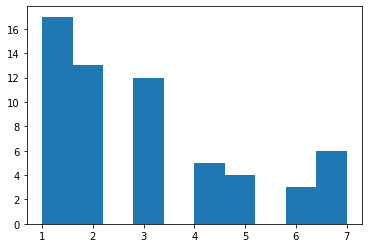

In [11]:
# Create a histogram for Great School based school rankings data looking for a normal distribution.
plt.hist(minneapolis_schools_df['GS Rank Stars'])
plt.show()

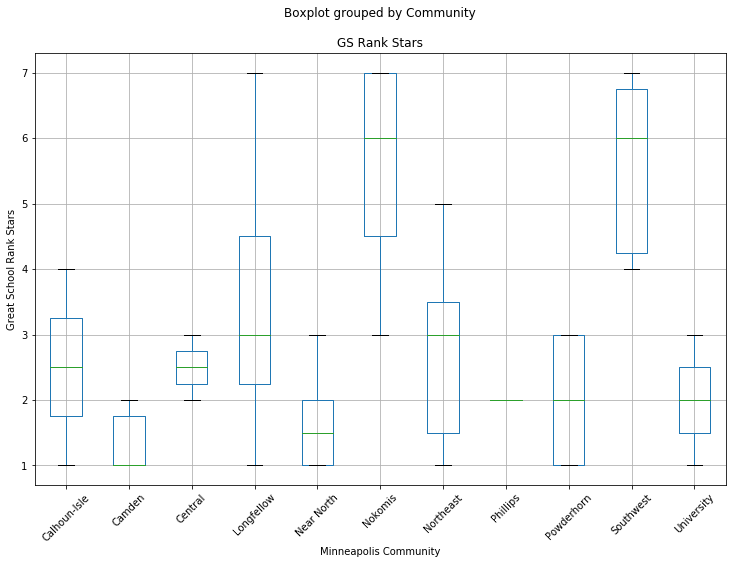

In [12]:
#DO A VISUAL CHECK BASED ON BOXPLOT BY COMMUNITY ASSESSED VALUE PER SQFT
#Conclusion: Means appear visually different. Lots of outliers.
minneapolis_schools_df.boxplot('GS Rank Stars', by='Community', figsize=(12, 8))
plt.xticks(rotation=45)
plt.xlabel('Minneapolis Community')
plt.ylabel('Great School Rank Stars')
plt.show()

In [13]:
minneapolis_schools_noNan_df = minneapolis_schools_df.fillna(0)
minneapolis_schools_noNan_df.tail(7)

,Unnamed: 0,Unnamed: 0.1,School ID,School Name,Latitude Longitude,Student Population,Free Discount Lunch,Students Per Teacher,GS Rank Stars,Rank Stars,Rank Level,Rank Statewide,Average Standard Score,Neighborhood,Community,LAT,LNG
95,95,95,2.720000e+11,Mps Metro C,"44.963751, -93.27428",18,83.33,2.5,0.0,0.0,0,0.0,0.0,Central Minneapolis,Central,44.963751,-93.27428
96,96,96,2.720000e+11,Mps Metro Ha,"44.994326, -93.256289",34,91.18,11.1,0.0,0.0,0,0.0,0.0,Northeast Minneapolis,Northeast,44.994326,-93.256289
97,97,97,2.720000e+11,Mps Metro Sj,"44.942078, -93.260772",23,86.96,5.7,0.0,0.0,0,0.0,0.0,Powderhorn Park,Powderhorn,44.942078,-93.260772
98,98,98,2.720000e+11,Nonpublic Sp Educational Program,"44.994326, -93.256289",0,0.00,0.0,0.0,0.0,0,0.0,0.0,Northeast Minneapolis,Northeast,44.994326,-93.256289
99,99,99,2.720000e+11,River Bend Educational Center,"44.981225, -93.299478",86,93.02,4.2,0.0,0.0,0,0.0,0.0,Glenwood Avenue,Near North,44.981225,-93.299478
100,100,100,2.720000e+11,Ronald McDonald House,"44.969978, -93.225907",7,0.00,8.2,0.0,0.0,0,0.0,0.0,Prospect Park,University,44.969978,-93.225907
101,101,101,2.720000e+11,Special Education,"44.994326, -93.256289",0,0.00,0.0,0.0,0.0,0,0.0,0.0,Northeast Minneapolis,Northeast,44.994326,-93.256289


In [14]:
# Define parameters needed for for school rankings for communities
grps = pd.unique(minneapolis_schools_noNan_df['Community'].values)
d_data = {grp:minneapolis_schools_noNan_df['GS Rank Stars'][minneapolis_schools_noNan_df['Community'] == grp] for grp in grps}

k = len(pd.unique(minneapolis_schools_noNan_df['Community']))  # number of conditions
N = len(minneapolis_schools_noNan_df.values)  # conditions times participants
n = minneapolis_schools_noNan_df.groupby('Community').size() # participants in each condition

In [69]:
# Do one-way Anova test for all 11 MSP communities based on school ratings
F, p = st.f_oneway(d_data['Calhoun-Isle'], d_data['Camden'], d_data['Central'], d_data['Longfellow'], d_data['Near North'],\
                   d_data['Nokomis'], d_data['Northeast'], d_data['Phillips'], d_data['Powderhorn'], d_data['Southwest'],\
                   d_data['University'])

one_way_anova_home_val = pd.DataFrame([{'F-stat':F, 'P-value':p}])
one_way_anova_home_val.style.format({"F-stat": "{:,.2f}", "P-Value": "{:,.5f}"})

,F-stat,P-value
0,5.06,0.000008


In [15]:
#Use Kruskal-Wallis H Test to check if data non-normal
stat, p = kruskal(d_data['Calhoun-Isle'], d_data['Camden'], d_data['Central'], d_data['Longfellow'], d_data['Near North'],\
                   d_data['Nokomis'], d_data['Northeast'], d_data['Phillips'], d_data['Powderhorn'], d_data['Southwest'],\
                   d_data['University'])
                  
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=23.222, p=0.010


In [16]:
# Using another method for Anova test - this code would not comile hence it is not run
#mod = ols("GS Rank Stars ~ Community", data=minneapolis_schools_noNan_df).fit()
#aov_table = sm.stats.anova_lm(mod, typ=2)
#aov_table

In [17]:
# Do pairwise T-test for each monnunity pair
#pair_t = mod.t_test_pairwise('Community')

This section of code is devoted to creating independent linear regressions of GS Rank Stars used as an independent variable
and look its infuence on possibly dependent variables House Value per Sqft and various metrics of Crime such as Total Crime
Rate and its components Violent Crime Rate and Non-Violent Crime Rate

In [18]:
# Create function to do various linear regression plots
def regression_plot(df,xname,yname,coord, fname):    
    x_values = df[xname]
    y_values = df[yname]
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_equation = "y = " + str(round(slope,2)) + " x + " + str(round(intercept,2))
    plt.scatter(x_values, y_values)    
    plt.plot(x_values, regress_values, "r-")
    plt.title(f"Plot {yname} vs. {xname}")
    plt.xlabel(f'{xname}')
    plt.ylabel(f'{yname}')
    plt.grid (b=True,which="major",axis="both",linestyle="-",color="lightgrey")
    plt.annotate(line_equation, coord, fontsize=13, color="red")
    print(f"The r-squared is: {rvalue**2:.2f}")    
    plt.savefig(fname)
    plt.show

The r-squared is: 0.06


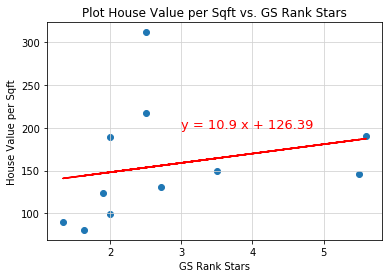

In [25]:
# Linear regression plot of GS Rank Start vs. House Value per Sqft
regression_plot(school_latlngy_data_df, 'GS Rank Stars', 'House Value per Sqft', (3, 200), 'png/Regr1.png')
plt.show()


In [29]:
# Data prep for home value vs. School data regression - excluding Central
school_noCentral_data_path = "data/csv_files/community_based_manual_school_data_noCentral.csv"
latlngy_noCentral_data_path = "data/csv_files/communities_valsqft_latlng_noCentral.csv"

# Read the school and location data and merge them for furher processing
school_noCentral_data = pd.read_csv(school_noCentral_data_path)
latlngy_noCentral_data = pd.read_csv(latlngy_noCentral_data_path)
school_latlngy_noCentral_data_df = pd.merge(school_noCentral_data, latlngy_noCentral_data, how="outer", on="Community")
school_latlngy_noCentral_data_df.head(10)


,Community,Student Population,Students Per Teacher,Free Discount Lunch,Average Standard Score,Rank Statewide,Rank Stars,GS Rank Stars,House Value per Sqft,LAT,LNG
0,Calhoun-Isle,444.000000,14.200000,64.770000,21.349087,18.372500,1.000000,2.500000,217.785079,44.959319,-93.306924
1,Camden,431.428571,13.300000,69.027143,8.295138,7.562000,0.166667,1.333333,89.854937,45.032955,-93.300300
2,Longfellow,272.857143,14.470000,67.209091,34.067445,31.716667,1.666667,3.500000,149.614650,44.948282,-93.227425
3,Near North,157.176471,9.010000,72.557143,3.763163,3.047143,0.000000,1.625000,80.650318,44.993191,-93.293128
4,Nokomis,480.200000,18.360000,27.554000,74.227782,77.390000,4.000000,5.500000,145.605115,44.906686,-93.237680
5,Northeast,261.714286,12.200000,69.600000,24.382581,20.754286,0.857143,2.714286,130.920763,45.015793,-93.249438
6,Phillips,312.666667,11.050000,60.946667,2.873000,2.560000,0.000000,2.000000,99.845649,44.956520,-93.257054
7,Powderhorn,436.533333,12.591667,73.456923,12.050402,10.860000,0.444444,1.888889,123.904829,44.938932,-93.258480
8,Southwest,725.384615,18.809091,27.779091,70.419420,70.815000,3.600000,5.600000,190.539065,44.916219,-93.298635
9,University,121.000000,12.733333,71.440000,14.364195,11.825000,0.333333,2.000000,189.266289,44.976498,-93.230213


The r-squared is: 0.21


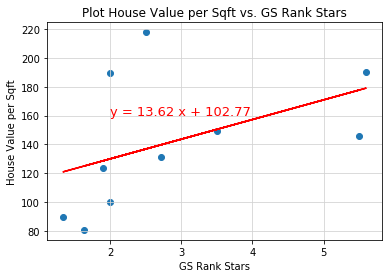

In [30]:
# Home value vs. School data regression - excluding Central
regression_plot(school_latlngy_noCentral_data_df, 'GS Rank Stars', 'House Value per Sqft', (2, 160), 'png/Regr2.png')
plt.show()

In [31]:
# Data prep for home value vs. School data regression - including Central
crime_data_path = "data/csv_files/Final Crime Stats.csv"

# Read the school and location data and merge them for furher processing
crime_data = pd.read_csv(crime_data_path)
school_crime_data_df = pd.merge(school_data, crime_data, how="outer", on="Community")
school_crime_data_df.head(11)

,Community,Student Population,Students Per Teacher,Free Discount Lunch,Average Standard Score,Rank Statewide,Rank Stars,GS Rank Stars,Population,Total Crime (2015-2020),Violent Crime (2015-2020),Non-Violent Crime (2015-2020),Total Crime Rate (per 1000 people),Violent Crime Rate (per 1000 people),Non-Violent Crime Rate (per 1000 people)
0,Calhoun-Isle,444.000000,14.200000,64.770000,21.349088,18.372500,1.000000,2.500000,30487,8893,2079,6814,58.34,13.64,44.70
1,Camden,431.428571,13.300000,69.027143,8.295138,7.562000,0.166667,1.333333,30586,7916,3966,3950,51.76,25.93,25.83
2,Central,137.833333,11.620000,70.376000,22.734155,19.290000,0.500000,2.500000,34490,19839,4466,15373,115.04,25.90,89.14
3,Longfellow,272.857143,14.470000,67.209091,34.067445,31.716667,1.666667,3.500000,28490,8612,2331,6281,60.46,16.36,44.09
4,Near North,157.176471,9.010000,72.557143,3.763163,3.047143,0.000000,1.625000,34902,8661,4203,4457,49.63,24.08,25.54
5,Nokomis,480.200000,18.360000,27.554000,74.227782,77.390000,4.000000,5.500000,38503,5164,2115,3049,26.82,10.99,15.84
6,Northeast,261.714286,12.200000,69.600000,24.382581,20.754286,0.857143,2.714286,38226,6629,2117,4511,34.68,11.08,23.60
7,Phillips,312.666667,11.050000,60.946667,2.873000,2.560000,0.000000,2.000000,22433,7211,2935,4276,64.29,26.17,38.12
8,Powderhorn,436.533333,12.591667,73.456923,12.050402,10.860000,0.444444,1.888889,58154,13741,5361,8380,47.26,18.44,28.82
9,Southwest,725.384615,18.809091,27.779091,70.419420,70.815000,3.600000,5.600000,49820,5625,1844,3781,22.58,7.40,15.18


The r-squared is: 0.18


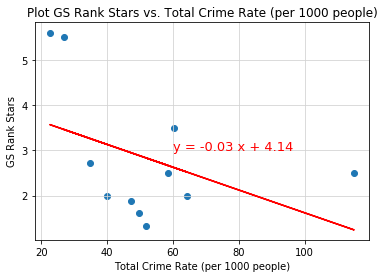

In [32]:
# Home value vs. School data regression - excluding Central
regression_plot(school_crime_data_df, 'Total Crime Rate (per 1000 people)', 'GS Rank Stars', (60, 3), 'png/Regr3.png')
plt.show()

The r-squared is: 0.44


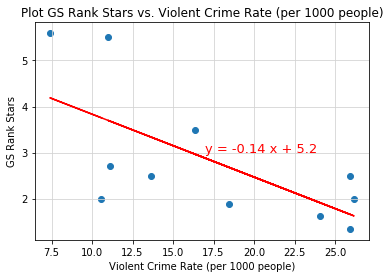

In [33]:
# Home value vs. School data regression - excluding Central
regression_plot(school_crime_data_df, 'Violent Crime Rate (per 1000 people)', 'GS Rank Stars',  (17, 3), 'png/Regr4.png')
plt.show()

The r-squared is: 0.08


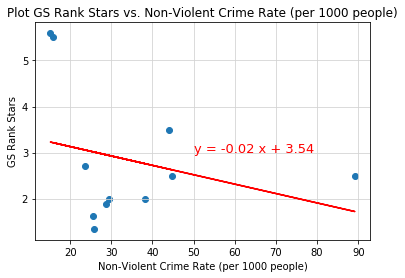

In [34]:
# Home value vs. School data regression - excluding Central
regression_plot(school_crime_data_df, 'Non-Violent Crime Rate (per 1000 people)', 'GS Rank Stars', (50, 3), 'png/Regr5.png')
plt.show()

In [37]:
# Data prep for home value vs. School data regression - including Central
crime_noCentral_data_path = "data/csv_files/Final Crime Stats - No Central.csv"

# Read the school and location data and merge them for furher processing
crime_noCentral_data = pd.read_csv(crime_noCentral_data_path)
school_crime_noCentral_data_df = pd.merge(school_noCentral_data, crime_noCentral_data, how="outer", on="Community")
school_crime_noCentral_data_df.head(10)

,Community,Student Population,Students Per Teacher,Free Discount Lunch,Average Standard Score,Rank Statewide,Rank Stars,GS Rank Stars,Population,Total Crime (2015-2020),Violent Crime (2015-2020),Non-Violent Crime (2015-2020),Total Crime Rate (per 1000 people),Violent Crime Rate (per 1000 people),Non-Violent Crime Rate (per 1000 people)
0,Calhoun-Isle,444.000000,14.200000,64.770000,21.349087,18.372500,1.000000,2.500000,30487,8893,2079,6814,58.34,13.64,44.70
1,Camden,431.428571,13.300000,69.027143,8.295138,7.562000,0.166667,1.333333,30586,7916,3966,3950,51.76,25.93,25.83
2,Longfellow,272.857143,14.470000,67.209091,34.067445,31.716667,1.666667,3.500000,28490,8612,2331,6281,60.46,16.36,44.09
3,Near North,157.176471,9.010000,72.557143,3.763163,3.047143,0.000000,1.625000,34902,8661,4203,4457,49.63,24.08,25.54
4,Nokomis,480.200000,18.360000,27.554000,74.227782,77.390000,4.000000,5.500000,38503,5164,2115,3049,26.82,10.99,15.84
5,Northeast,261.714286,12.200000,69.600000,24.382581,20.754286,0.857143,2.714286,38226,6629,2117,4511,34.68,11.08,23.60
6,Phillips,312.666667,11.050000,60.946667,2.873000,2.560000,0.000000,2.000000,22433,7211,2935,4276,64.29,26.17,38.12
7,Powderhorn,436.533333,12.591667,73.456923,12.050402,10.860000,0.444444,1.888889,58154,13741,5361,8380,47.26,18.44,28.82
8,Southwest,725.384615,18.809091,27.779091,70.419420,70.815000,3.600000,5.600000,49820,5625,1844,3781,22.58,7.40,15.18
9,University,121.000000,12.733333,71.440000,14.364195,11.825000,0.333333,2.000000,45061,8996,2383,6612,39.93,10.58,29.35


The r-squared is: 0.46


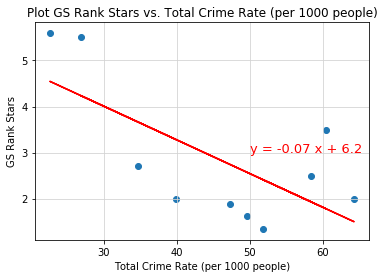

In [38]:
# Home value vs. School data regression - excluding Central
regression_plot(school_crime_noCentral_data_df, 'Total Crime Rate (per 1000 people)', 'GS Rank Stars', (50, 3), 'png/Regr6.png')
plt.show()

The r-squared is: 0.48


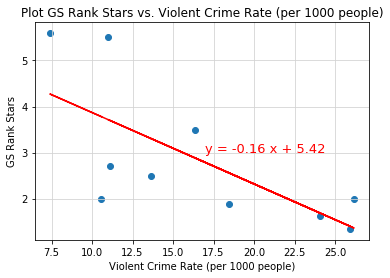

In [39]:
# Home value vs. School data regression - excluding Central
regression_plot(school_crime_noCentral_data_df, 'Violent Crime Rate (per 1000 people)', 'GS Rank Stars', (17, 3), 'png/Regr7.png')
plt.show()

The r-squared is: 0.21


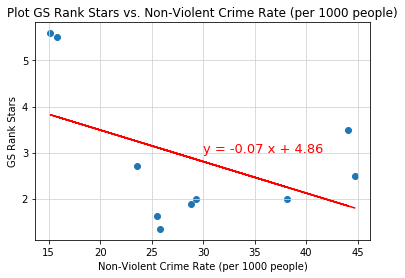

In [40]:
# Home value vs. School data regression - excluding Central
regression_plot(school_crime_noCentral_data_df, 'Non-Violent Crime Rate (per 1000 people)', 'GS Rank Stars', (30, 3), 'png/Regr8.png')
plt.show()

These statistics were collected and analyzed by the team while trying to figure out if school rankings can possibly affect
housing values in the Minneapolis school district area.